In [1]:
import os
import tensorflow as tf

from PIL import UnidentifiedImageError

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)

# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)

# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# for plotting
import numpy as np
import matplotlib.pyplot as plt

2024-04-10 20:59:48.253058: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:59:48.256873: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 20:59:48.345858: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 20:59:49.437182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_history(H, epochs, outpath):
    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label = "train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label = "val_loss", linestyle = ":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label = "train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label = "val_acc", linestyle = ":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()
    plt.savefig(outpath)


In [3]:
folder_path = os.path.join("../../../../cds-vis-data/Tobacco3482")

# Initialize empty lists
list_of_images = [] 
list_of_labels = []

# Loop through subfolders
for subfolder in sorted(os.listdir(folder_path)):

        # Extract images from the individual folders
        subfolder_path  = os.path.join(folder_path, subfolder)

        for file in os.listdir(subfolder_path):
                
                individual_filepath = os.path.join(subfolder_path, file)

                try:
                        # Load image from file
                        image = load_img(individual_filepath, target_size = (224, 224))
                        # Convert the image pixels to a numpy array
                        image = img_to_array(image)
                        list_of_images.append(image)

                        # Extract image name and append to list
                        #image_name = individual_filepath.split("/")[-1]
                        #list_of_images.append(image_name)

                        # Extract label and append to list
                        label = subfolder_path.split("/")[-1]
                        list_of_labels.append(label)
                        
                        # Append the preprocessed image along with its label as a tuple
                        #list_of_images.append((image, label))

                except (UnidentifiedImageError):
                        print(f"Skipping {individual_filepath}")

array_of_images = np.array(list_of_images)
X = preprocess_input(array_of_images)
y = list_of_labels


Skipping ../../../../cds-vis-data/Tobacco3482/ADVE/Thumbs.db
Skipping ../../../../cds-vis-data/Tobacco3482/Email/Thumbs.db


In [11]:
def load_images(folder_path):
        
        # Initialize empty lists
        list_of_images = [] 
        list_of_labels = []

        for subfolder in sorted(os.listdir(folder_path)):
                
                # Extract images from the individual folders
                subfolder_path  = os.path.join(folder_path, subfolder)
                
                for file in os.listdir(subfolder_path):
                        
                        individual_filepath = os.path.join(subfolder_path, file)
                        
                        try:
                                # Load image from file
                                image = load_img(individual_filepath, target_size = (224, 224))

                                # Convert the image pixels to a numpy array
                                image = img_to_array(image)

                                list_of_images.append(image)

                                # Extract image name and append to list
                                #image_name = individual_filepath.split("/")[-1]
                                #list_of_images.append(image_name)

                                # Extract label and append to list
                                label = subfolder_path.split("/")[-1]
                                list_of_labels.append(label)
                
                        except (UnidentifiedImageError):
                                print(f"Skipping {individual_filepath}")
        
        array_of_images = np.array(list_of_images)
        X = preprocess_input(array_of_images)
        y = list_of_labels
        
        return X, y


In [23]:
preprocessed_images = []

for image in list_of_images:
#for image_tuple in list_of_images: 
    #image = image_tuple[0]  # Extract the image from the tuple
    #label = image_tuple[1]  # Extract the label from the tuple

    # Convert the image pixels to a numpy array
    #image_array = img_to_array(image)

    # reshape data to 4D tensor (shape = [number of images, height, width, number of color-channels])
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prepare the image for the VGG model
    image = preprocess_input(image)
    
    # append the preprocessed image along with its label as a tuple
    preprocessed_images.append(image)


In [21]:

def preprocess_images(list_of_images):

    # Initialize empty lists
    preprocessed_images = []

    for image_tuple in list_of_images:
        image = image_tuple[0]  # Extract the image from the tuple
        label = image_tuple[1]

        # convert the image pixels to a numpy array
        image = img_to_array(image) 

        # reshape data to 4D tensor (shape = [number of images, height, width, number of color-channels])
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)

        # append to list
        preprocessed_images.append(image)

    return preprocessed_images


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)   # shape (2785, 10)
y_test = lb.fit_transform(y_test)     # shape (697, 10)


In [ ]:
# Finetune the VGG16 model on new data

# Split data into train and test:

# Extract images and labels from the tuble into separate lists

X = preprocessed_images
y = list_of_labels

#X = np.array([image for image, label in preprocessed_images])
#y = np.array([label for image, label in preprocessed_images])

# Split data into training and testing sets. 'stratify' ensures that all labels are represented in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)

# normalize
X_train = X_train.astype("float32") / 255.
X_test = X_test.astype("float32") / 255.

# one-hot encondings
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)   # shape (2785, 10)
y_test = lb.fit_transform(y_test)     # shape (697, 10)

# Tensor shape 4D (num of images, 224, 224, 3)
#X_train = np.reshape(X_train, (X_train.shape[0],) + X_train.shape[2:])  # shape (2785, 224, 224, 3)
#X_test = np.reshape(X_test, (X_test.shape[0],) + X_test.shape[2:])      # shape (697, 224, 224, 3)

# Scale image features
#def scale(X):
#    scaled_images  = X  / 255.0
#    return scaled_images 

In [ ]:
def data_split(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
    X_train = X_train.astype("float32") / 255.
    X_test = X_test.astype("float32") / 255.
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test) 

    return X_train, X_test, y_train, y_test

Vi kører alle
```
model = VGG16()

# skal vi alle gøre - load model without classifier layers
model = VGG16(include_top = False,        # dont use the final layer of the classifier
              pooling = 'avg',
              input_shape = (32, 32, 3))  # (height, width, number of color-channels)

# skal vi alle gøre - mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
```

1. Ida kører clean model:
```
flat1 = Flatten()(model.layers[-1].output)  # take final layer (-1) in the model and append to flat1
class1 = Dense(128, activation = 'relu')(flat1)
output = Dense(10, activation = 'softmax')(class1)
```

2. Laura kører BatchNorm
```
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)
class1 = Dense(128, 
               activation='relu')(bn)
output = Dense(10, 
               activation='softmax')(class2)
```

3. Jeg Sofie kører data argumentation - nedenstående

4. Alle kører både sgd og adam!
```
sgd = SGD(learning_rate=lr_schedule)
adam = Adam(learning_rate=lr_schedule)
```

In [ ]:
# load model without classifier layers
model = VGG16(include_top = False, 
              pooling = 'avg',
              input_shape = (224, 224, 3)) 

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)
class2 = Dense(128, 
               activation='relu')(bn)
output = Dense(10, 
               activation='softmax')(class2)

# define new model
model = Model(inputs = model.inputs, 
              outputs = output)

# compile
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9)
    
sgd = SGD(learning_rate=lr_schedule)
#adam = Adam(learning_rate=lr_schedule)

model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# summarize
model.summary()

In [7]:
# Define data generator

# Add noise to an image
def add_noise(img):
    noise = np.random.normal(0, scale = 25, size = img.shape)
    noisy_image = np.clip(image + noise, 0, 255) #.astype(np.uint8)
    return noisy_image

# flip along x axis (mirror image)
datagen = ImageDataGenerator(horizontal_flip = True, 
                             rotation_range = 90,
                             preprocessing_function = add_noise,
                             validation_split = 0.1)


In [8]:
# Train

# fit the data generator to our images
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
H = model.fit(datagen.flow(X_train, y_train, batch_size = 128), 
                            validation_data = datagen.flow(X_train, y_train, 
                                                           batch_size = 64, 
                                                           subset = "validation"),
                                                           epochs = 20)   # training for less time

# batch_size 128
# epochs 10
# 1 epoch 358s 
# fra 19.58 til 20:51

# new test 
# batch 64
# epochs 20

Epoch 1/10


/home/ucloud/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-10 19:58:30.397984: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 19:58:36.546636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 358s 16s/step - accuracy: 0.1418 - loss: 2.4374 - val_accuracy: 0.1583 - val_loss: 16.0289
Epoch 2/10


2024-04-10 20:04:27.459833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:04:33.381429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 351s 15s/step - accuracy: 0.1712 - loss: 2.2178 - val_accuracy: 0.1583 - val_loss: 7.3275
Epoch 3/10


2024-04-10 20:10:18.438767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:10:24.148722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 349s 15s/step - accuracy: 0.1667 - loss: 2.2025 - val_accuracy: 0.1583 - val_loss: 5.5431
Epoch 4/10


2024-04-10 20:16:09.457308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-04-10 20:16:13.643838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 352s 16s/step - accuracy: 0.1510 - loss: 2.2050 - val_accuracy: 0.1583 - val_loss: 3.4204
Epoch 5/10


2024-04-10 20:21:59.847496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:22:06.143791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 350s 15s/step - accuracy: 0.1785 - loss: 2.1779 - val_accuracy: 0.1691 - val_loss: 2.5320
Epoch 6/10


2024-04-10 20:27:50.064885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:27:56.970655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 349s 15s/step - accuracy: 0.1929 - loss: 2.1830 - val_accuracy: 0.1583 - val_loss: 2.2360
Epoch 7/10


2024-04-10 20:33:38.757624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:33:45.979142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 349s 15s/step - accuracy: 0.1728 - loss: 2.1820 - val_accuracy: 0.1763 - val_loss: 2.1792
Epoch 8/10


2024-04-10 20:39:28.063358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:39:34.525336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 345s 15s/step - accuracy: 0.1656 - loss: 2.1739 - val_accuracy: 0.1942 - val_loss: 2.1335
Epoch 9/10


2024-04-10 20:45:13.257934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:45:20.253989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 347s 15s/step - accuracy: 0.1591 - loss: 2.1682 - val_accuracy: 0.2122 - val_loss: 2.1703
Epoch 10/10


2024-04-10 20:51:01.136045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 5 of 8
2024-04-10 20:51:08.045419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 348s 15s/step - accuracy: 0.1716 - loss: 2.1738 - val_accuracy: 0.2050 - val_loss: 2.1407


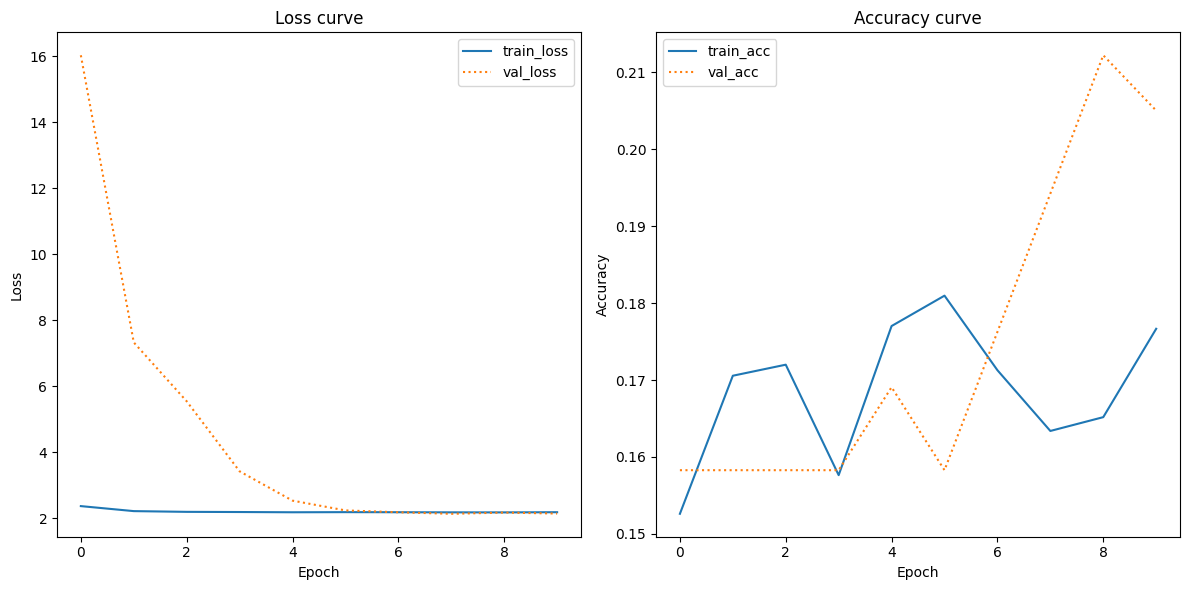

<Figure size 640x480 with 0 Axes>

In [9]:
# Inspect

plot_history(H, 10, "out/VGG16_losscurve_data_augmentation_sgd-new.png")

In [10]:
# Evaluate
label_names = ["ADVE", "Email", "Form", "Letter", "Memo", "News", "Note", "Report", "Resume", "Scientific"]

predictions = model.predict(X_test, batch_size = 128)
classifier_metrics = classification_report(y_test.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = label_names)


print(classifier_metrics)

filepath_metrics = open('out/VGG16_metrics_data_augmentation_sgd-new.txt', 'w')
filepath_metrics.write(classifier_metrics)
filepath_metrics.close()


6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step
              precision    recall  f1-score   support

        ADVE       0.00      0.00      0.00        46
       Email       0.00      0.00      0.00       120
        Form       0.00      0.00      0.00        86
      Letter       0.00      0.00      0.00       114
        Memo       0.18      1.00      0.30       124
        News       0.00      0.00      0.00        38
        Note       0.00      0.00      0.00        40
      Report       0.00      0.00      0.00        53
      Resume       0.00      0.00      0.00        24
  Scientific       0.00      0.00      0.00        52

    accuracy                           0.18       697
   macro avg       0.02      0.10      0.03       697
weighted avg       0.03      0.18      0.05       697



/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ucloud/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def eval_model(X_test, y_test, model, H, optimizer):

    predictions = model.predict(X_test)
    VGG16_metrics = classification_report(y_test.argmax(axis = 1),
                                            predictions.argmax(axis = 1),
                                            target_names = label_names)
    filepath_metrics = open(f'out/VGG16_metrics{optimizer}.txt', 'w')
    filepath_metrics.write(VGG16_metrics)
    filepath_metrics.close()

    plot_history(H, 5, f"../out/VGG16_losscurve{optimizer}.png")

    return print("Results have been saved to the out folder")

In [ ]:
filepath_report = "out/LR_classification_report.txt"
    with open(filepath_report, 'w') as file:
        file.write(classifier_metrics)

In [40]:
def main():
    folder_path = os.path.join("../../../../cds-vis-data/Tobacco3482/") # change to in for the final script
    
    list_of_images, list_of_labels = load_images(folder_path)
    
    preprocessed_images = preprocess_images(list_of_images)
    #preprocessed_images = [(preprocess_images(image), label) for image, label in preprocessed_images]
